# Demo: Processing and interpreting magnetic data

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.loadtxt('GoiasAlkalineProvince.txt', skiprows=1)[::3].T

In [3]:
from fatiando import gridder

In [4]:
area = [-51.249994, -51.156775, -16.199155, -16.125]
_, _, [x, y, height, topo, tfa] = gridder.cut(data[-2], data[-1], [data[1], data[0], data[2], data[4], data[5]], area)

In [5]:
x -= x.min()
y -= y.min()

In [71]:
np.savetxt('mag-data.txt', np.transpose([x, y, -height, topo, tfa]), fmt='%.5f')

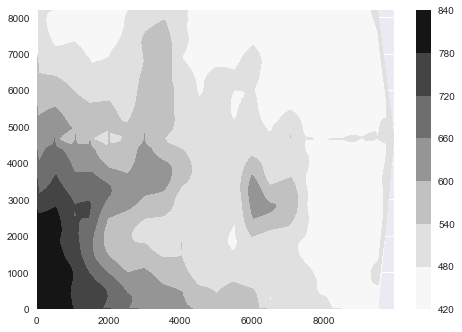

In [68]:
plt.tricontourf(y, x, height)
plt.colorbar()

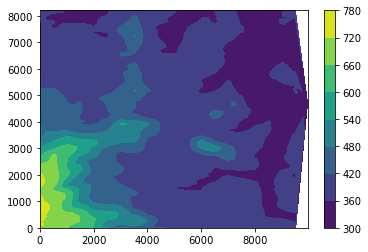

In [7]:
plt.tricontourf(y, x, topo)
plt.colorbar()

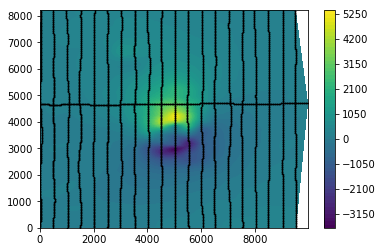

In [8]:
plt.plot(y, x, 'xk', markersize=1)
plt.tricontourf(y, x, tfa, 60)
plt.colorbar()

In [9]:
tfa.size

7095

In [10]:
np.sqrt(tfa.size)

84.231822964957843

In [11]:
inc, dec = -19.5, -18.5

In [12]:
del data

In [13]:
from fatiando.gravmag.eqlayer import EQLTotalField
from fatiando.inversion import Damping
from fatiando.mesher import PointGrid
from fatiando import utils

/home/leo/bin/anaconda/envs/tgif-demo/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [14]:
area = [x.min(), x.max(), y.min(), y.max()]
layer = PointGrid(area, z=-100, shape=(80, 80))

In [15]:
misfit = EQLTotalField(x, y, z=-height, data=tfa, inc=inc, dec=dec, grid=layer)
regul = Damping(misfit.nparams)

In [16]:
eql = misfit + 1e-15*regul

In [17]:
%%time
eql.fit()

CPU times: user 23.8 s, sys: 884 ms, total: 24.7 s
Wall time: 14.4 s


In [18]:
eql.estimate_

array([  -767336.60865717,   1592588.3652199 ,   4896565.87783079, ...,
       -17092323.07655634, -15505185.85620457, -14534311.75862153])

In [19]:
layer.addprop('magnetization', utils.ang2vec(eql.estimate_, inc, dec))

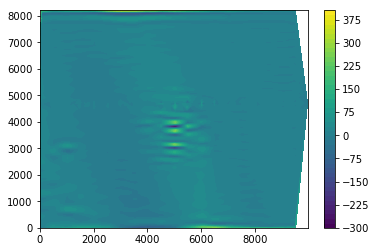

In [20]:
plt.tricontourf(y, x, eql[0].residuals(), 60)
plt.colorbar()

(array([  2.00000000e+00,   4.00000000e+00,   2.40000000e+01,
          2.36000000e+02,   6.68900000e+03,   9.80000000e+01,
          2.40000000e+01,   1.20000000e+01,   2.00000000e+00,
          4.00000000e+00]),
 array([-298.27001921, -228.03320554, -157.79639186,  -87.55957819,
         -17.32276452,   52.91404915,  123.15086283,  193.3876765 ,
         263.62449017,  333.86130384,  404.09811751]),
 <a list of 10 Patch objects>)

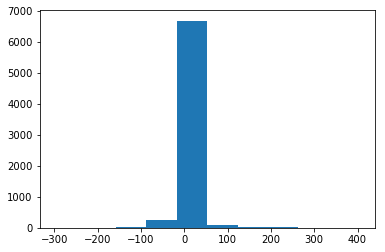

In [21]:
plt.hist(eql[0].residuals())

In [22]:
from fatiando.gravmag import sphere
from fatiando import gridder

In [23]:
shape = (85, 85)
xp, yp, zp = gridder.regular(area, shape=shape, z=-700)

In [24]:
-height

array([-812.77, -813.78, -814.86, ..., -636.66, -638.4 , -640.01])

In [25]:
xp

array([    0.  ,     0.  ,     0.  , ...,  8202.03,  8202.03,  8202.03])

In [26]:
tfa_grid = sphere.tf(x, y, -height, layer, inc, dec)

In [27]:
tfa_grid = sphere.tf(xp, yp, zp, layer, inc, dec)

In [28]:
tfa_grid

array([ 83.88321014,  86.35009846,  82.59849299, ...,  77.11884871,
        84.45191575,  91.42568447])

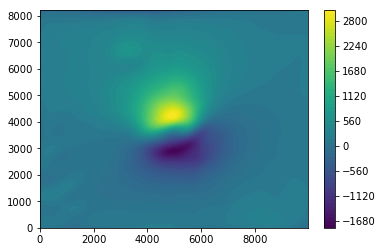

In [29]:
plt.tricontourf(yp, xp, tfa_grid, 60)
plt.colorbar()

In [30]:
from fatiando.gravmag import transform

In [32]:
tga = transform.tga(xp, yp, tfa_grid, shape)

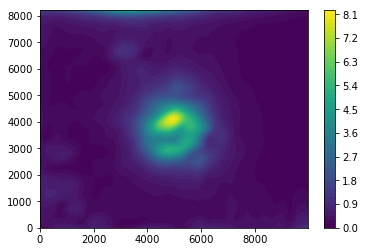

In [33]:
plt.tricontourf(yp, xp, tga, 60)
plt.colorbar()

In [63]:
pole = transform.reduce_to_pole(xp, yp, tfa_grid, shape, inc, dec, inc, dec)

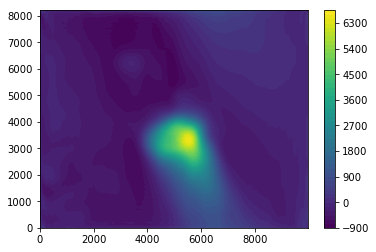

In [64]:
plt.tricontourf(yp, xp, pole, 60)
plt.colorbar()

In [48]:
from fatiando.gravmag.euler import EulerDeconvEW
from fatiando.gravmag.magdir import DipoleMagDir

In [53]:
dx = transform.derivx(xp, yp, tfa_grid, shape)
dy = transform.derivy(xp, yp, tfa_grid, shape)
dz = transform.derivz(xp, yp, tfa_grid, shape)
euler = EulerDeconvEW(xp, yp, zp, tfa_grid, dx, dy, dz, structural_index=3, center=[4000, 5000], sizes=range(500, 8000, 500))

In [54]:
euler.fit()

In [55]:
euler.estimate_

array([ 3684.09587513,  5253.60075365,   627.67749843])

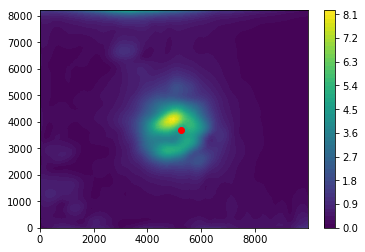

In [57]:
plt.tricontourf(yp, xp, tga, 60)
plt.colorbar()
plt.plot(euler.estimate_[1], euler.estimate_[0], 'ro')

In [58]:
mag = DipoleMagDir(xp, yp, zp, tfa_grid, inc, dec, [euler.estimate_]).fit()

In [59]:
mag.estimate_

[[6908.4450952478555, -63.578688588805356, -39.964109312977968]]

In [60]:
inc, dec

(-19.5, -18.5)

In [62]:
sinc, sdec = mag.estimate_[0][1:]

In [65]:
pole = transform.reduce_to_pole(xp, yp, tfa_grid, shape, inc, dec, sinc, sdec)

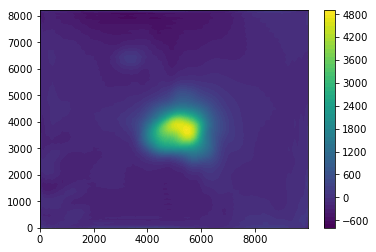

In [66]:
plt.tricontourf(yp, xp, pole, 60)
plt.colorbar()